In [6]:
from scipy.sparse import csr_matrix
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from quantumScarsCheck import *
from quantumScarsPlotting import *
from quantumScarFunctions import *

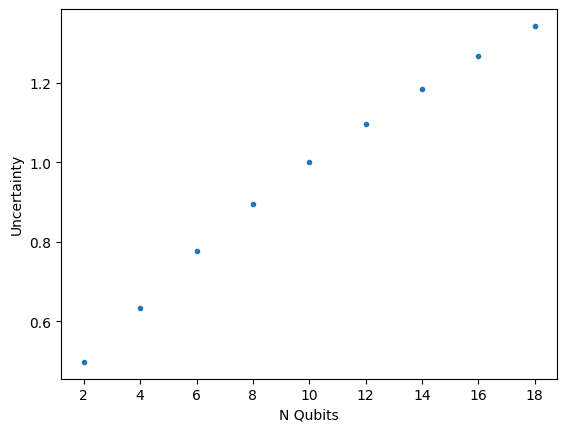

In [7]:
nlist = list(range(2, 20, 2))
uncertaintyList = []

for N in nlist:    
    basisList = binNoConsecOnesEfficient(N)
    for basis in basisList:
        if basis[0] == '1' and basis[-1] == '1':
            basisList.remove(basis)
    #print(basisList)
        
    basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
    # print(basisMap)
    basisLen = len(basisList)
    flippedList = []
    ohms = 1.0

    rowBare = []
    columnBare = []

    rowFactor = []
    columnFactor = []

    # flip bit hashmap
    flipMap = {'0': '1', '1': '0'}

    # sigma z op hashmap
    sigzMap = {'0': '-1', '1': '1'}

    # list of ints for Hamiltonian
    numList = []

    # -------------------------------
    #
    # create the bare PXP hamiltonian
    #
    # -------------------------------
    # the padded variables are not padded
    for i in range(basisLen):

        # add padding so that search doesnt go out of range
        paddedBitStr = basisList[i][-1] + basisList[i] + basisList[i][0]
        copyBit = list(paddedBitStr)

        # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
        for j in range(1, N+1):
            
            if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
                copyBit[j] = flipMap[paddedBitStr[j]]
                flippedList.append(''.join(copyBit)[1:-1])
                copyBit = list(paddedBitStr)
            
        # adds row and column values for the sparse matrix
        for k in range(len(flippedList)):
            rowBare.append(basisMap[flippedList[k]])
            columnBare.append(i)
            
        flippedList.clear()

    # -------------------------------
    #
    # create the sigma Z PXP hamiltonian perturbation
    #
    # -------------------------------

    # print(basisList)
    # print()

    for i in range(basisLen):

        # add padding so that search doesnt go out of range
        paddedBitStr = basisList[i][-2] + basisList[i][-1] + basisList[i] + basisList[i][0] + basisList[i][1]
        copyBit = list(paddedBitStr)
        factor = 1

        # apply the PXP operator
        for j in range(2, N+2):
            
            if (paddedBitStr[j-1] == '0') and (paddedBitStr[j+1] == '0'):
                copyBit[j] = flipMap[paddedBitStr[j]]

                # apply sigmaZ_r-2 + sigmaZ_r+2
                r_neg2 = int(sigzMap[paddedBitStr[j-2]])
                r_pos2 = int(sigzMap[paddedBitStr[j+2]])
                factor = r_neg2 + r_pos2
                numList.append(factor)

                flippedList.append(''.join(copyBit)[2:-2])
                copyBit = list(paddedBitStr)
            
        # print(flippedList)

        # adds row and column values for the sparse matrix
        for k in range(len(flippedList)):
            rowFactor.append(basisMap[flippedList[k]])
            columnFactor.append(i)
            
        flippedList.clear()

    # list of ones for the sparse matrix
    onesList = np.ones(len(rowBare), dtype=int)

    # create the sparse matrix and turn it into a Qobj
    sparseBareHamiltonian = csr_matrix((onesList, (rowBare, columnBare)), shape=[basisLen, basisLen])
    matrixBareHamiltonian = sparseBareHamiltonian.toarray()

    sparseFactoredHamiltonian = csr_matrix((numList, (rowFactor, columnFactor)), shape=[basisLen, basisLen])
    matrixFactoredHamiltonian = sparseFactoredHamiltonian.toarray()

    H0 = (ohms / 2 * sparseBareHamiltonian) + (-0.026 * ohms * sparseFactoredHamiltonian)

    # print()
    # print(H0)

    H0 = qt.Qobj(H0)

    # -------------------------------
    #
    # states and evolutions set ups
    #
    # -------------------------------

    # diagonalize the sparse matrix
    eigenvalues, eigenstates = H0.eigenstates()

    # initial state
    z2_str = z2_initial(N)
    #print(z2_str)
    z2_index = basisMap[z2_str]
    psi0 = qt.basis(basisLen, z2_index)

    uncertaintyList.append(np.sqrt((psi0.dag() * H0**2 * psi0) - (psi0.dag() * H0 * psi0)**2))

plt.plot(nlist, uncertaintyList, ".")
plt.xlabel("N Qubits")
plt.ylabel("Uncertainty")
plt.show()